In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

In [2]:
import graphufs
from graphufs.lineplot import LinePlotter

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
plt.style.use("graphufs.plotstyle")

In [4]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})

    if "lead_time" in xds.coords:
        xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
        xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [6]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [7]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [8]:
truths = ["HRES Analysis", "ERA5"]
models = [
    "GraphUFS p1",
    "GraphUFS p2",
    "GraphCast",
    "Pangu",
    "IFS ENS Mean",
    "Replay",
]

In [18]:
duration = "240h"
year = 2018

errors = {}

for model in models:
    name = model.lower().replace(" ", "_")
    errors[model] = {}
    middle = duration if model in ("GraphUFS p1", "GraphUFS p2", "Replay", "Replay Targets", "GraphUFS GDM", "GraphUFS GDMv2", "GraphUFS 6h") else year
    if "GDM" in model:
        if "v2" in model:
            name = name.replace("v2","")
            location = "/gdm-eval/v2/validation" 
        else:
            location = "/gdm-eval/v1/validation"
    elif "p2" in model or "Replay" in model:
        location = "/p2-lustre/p2/inference/validation"
    else:
        location = "/p1-evaluation/v1/validation"
    
    for truth in truths:
        tname = truth.lower().replace(" ", "_")
        readname = name if "p1" not in name and "p2" not in name else name[:-3]
        errors[model][truth] = open_dataset(f"{location}/{readname}_vs_{tname}_{middle}_deterministic.nc")

In [19]:
lp = LinePlotter()

## MAE vs HRES

In [20]:
color = {"GraphUFS p1": "C0", "GraphUFS p2": "C0"}
ls = {"GraphUFS p1": "--"}

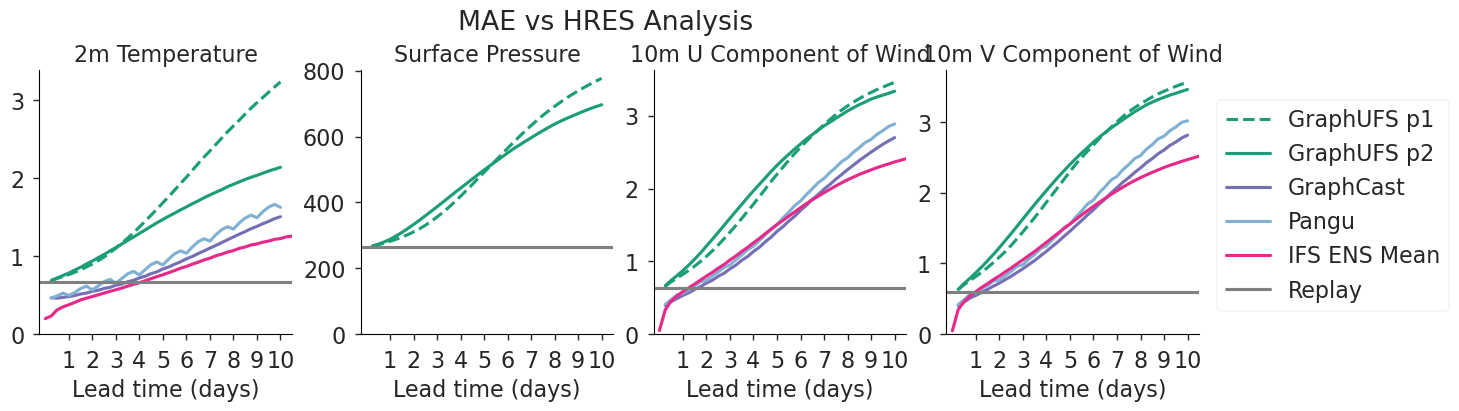

In [44]:
fig, axs = lp.plot_surface(
    errors,
    truth="HRES Analysis",
    fields=("2m_temperature", "surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"),
    color=color,
    linestyle=ls,
)
fig.savefig(f"{fig_dir}/mae_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

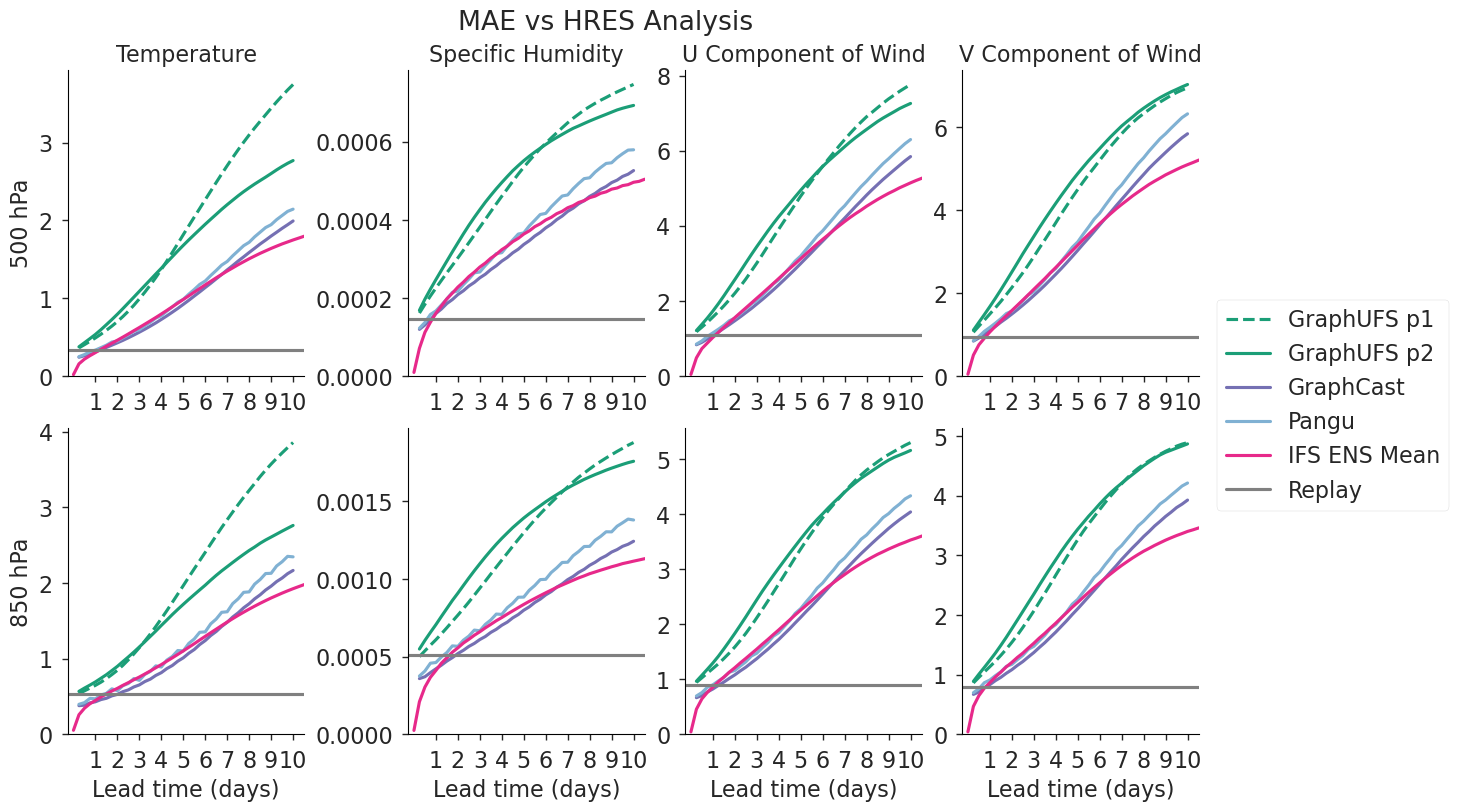

In [45]:
fig, axs = lp.plot_levels(errors, truth="HRES Analysis", levels=(500, 850), color=color, linestyle=ls)
fig.savefig(f"{fig_dir}/mae_vs_hres_levels.jpeg", bbox_inches="tight", dpi=300)

## MAE vs ERA5

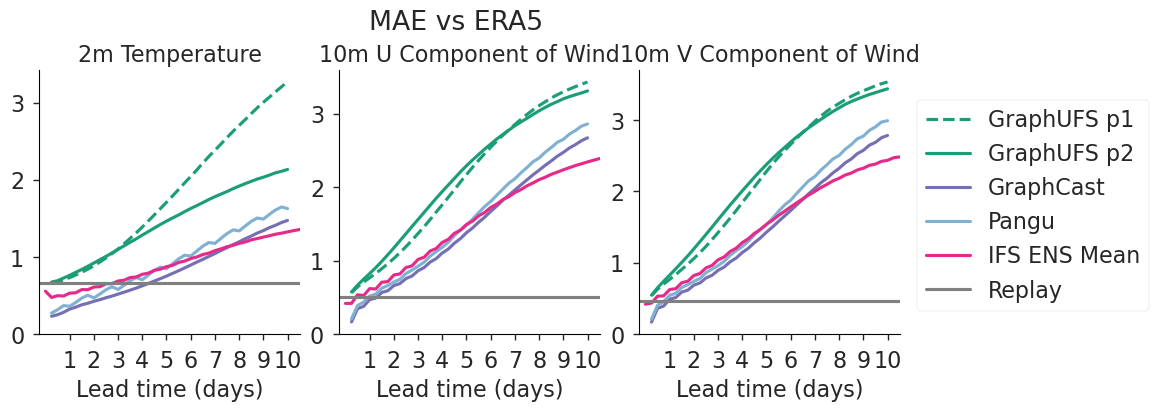

In [46]:
fig, axs = lp.plot_surface(errors, truth="ERA5", color=color, linestyle=ls)
fig.savefig(f"{fig_dir}/mae_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

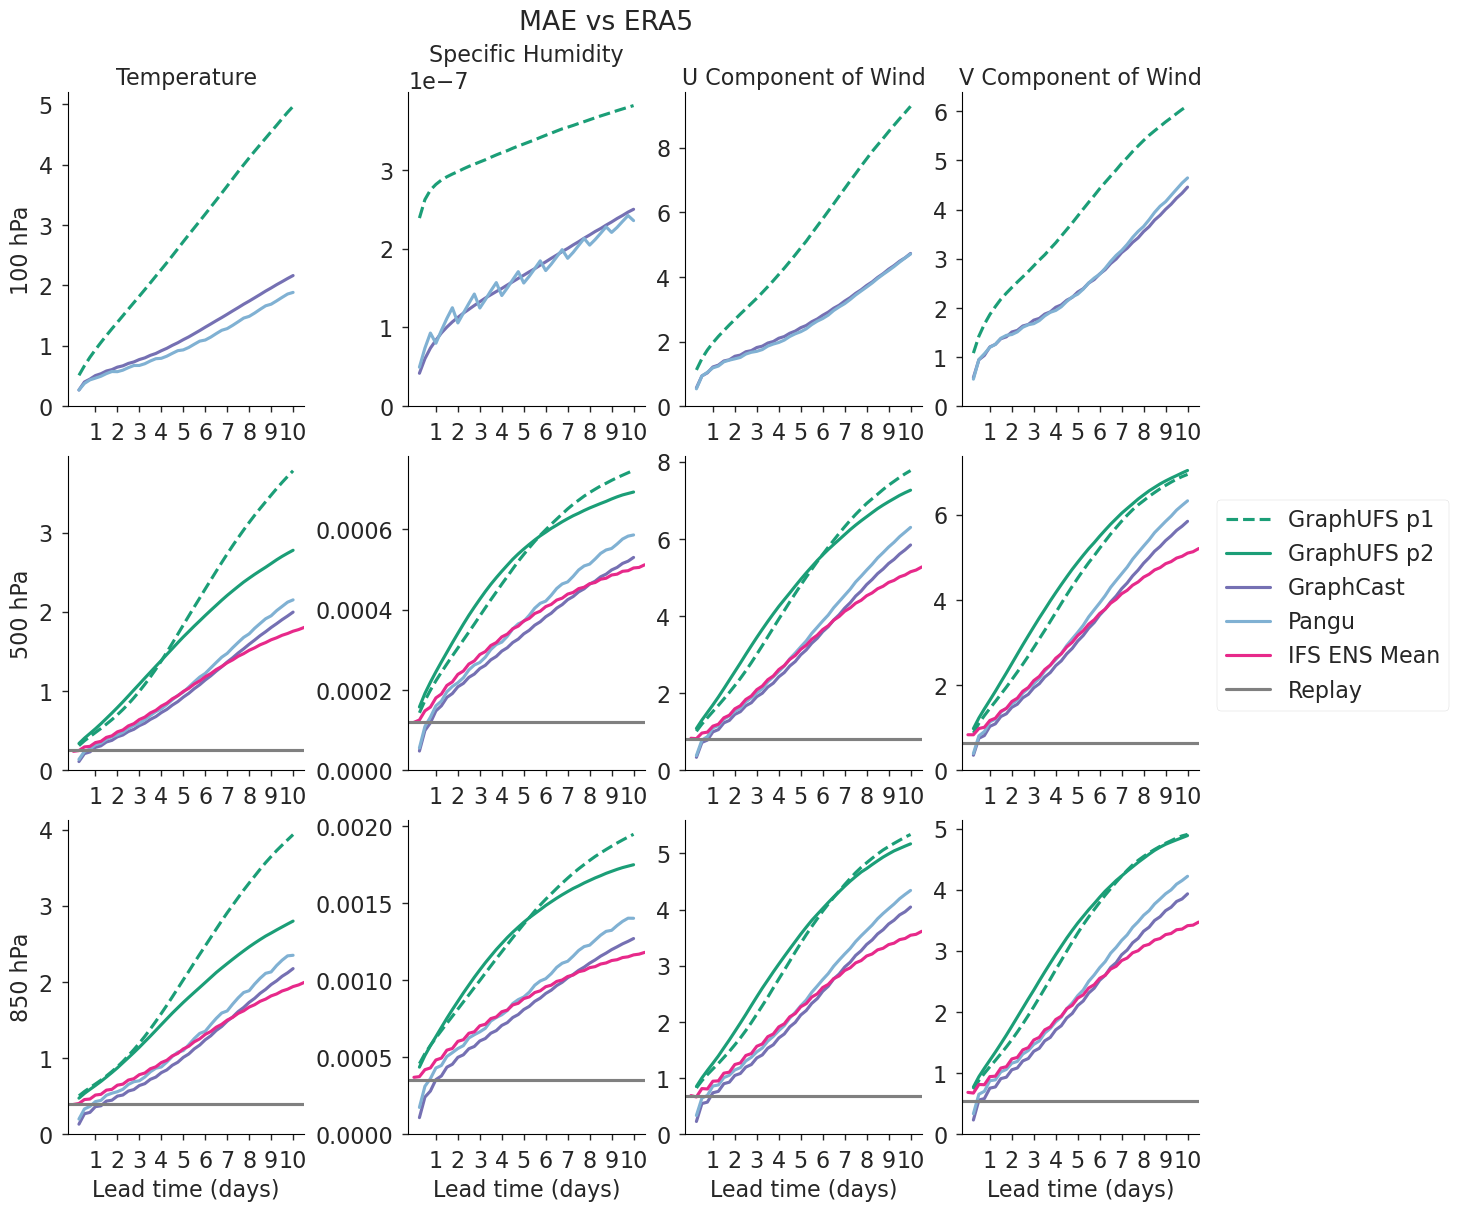

In [47]:
fig, axs = lp.plot_levels(errors, truth="ERA5", color=color, linestyle=ls)
fig.savefig(f"{fig_dir}/mae_vs_era5_levels.jpeg", bbox_inches="tight", dpi=300)

## ACC vs ERA5

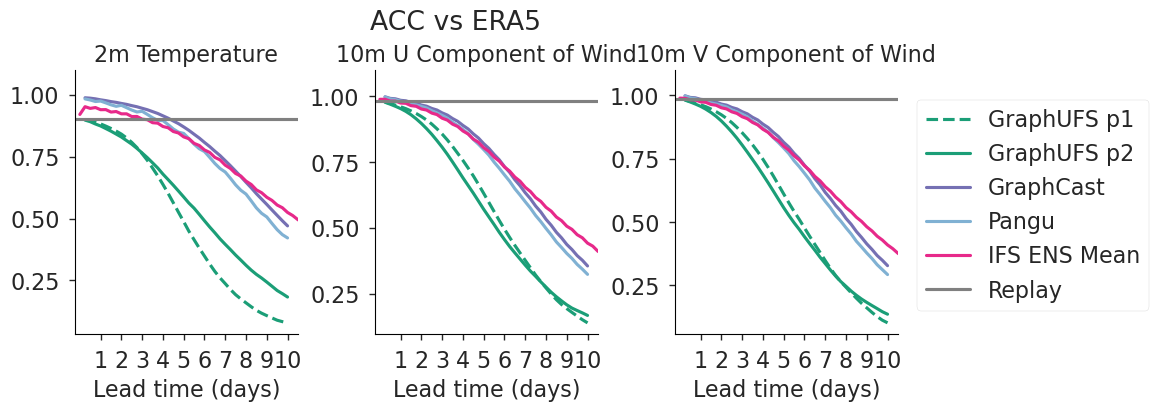

In [48]:
fig, axs = lp.plot_surface(errors, truth="ERA5", metric="acc", color=color, linestyle=ls)
[ax.set(ylim=[None, 1.1]) for ax in axs]
fig.savefig(f"{fig_dir}/acc_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

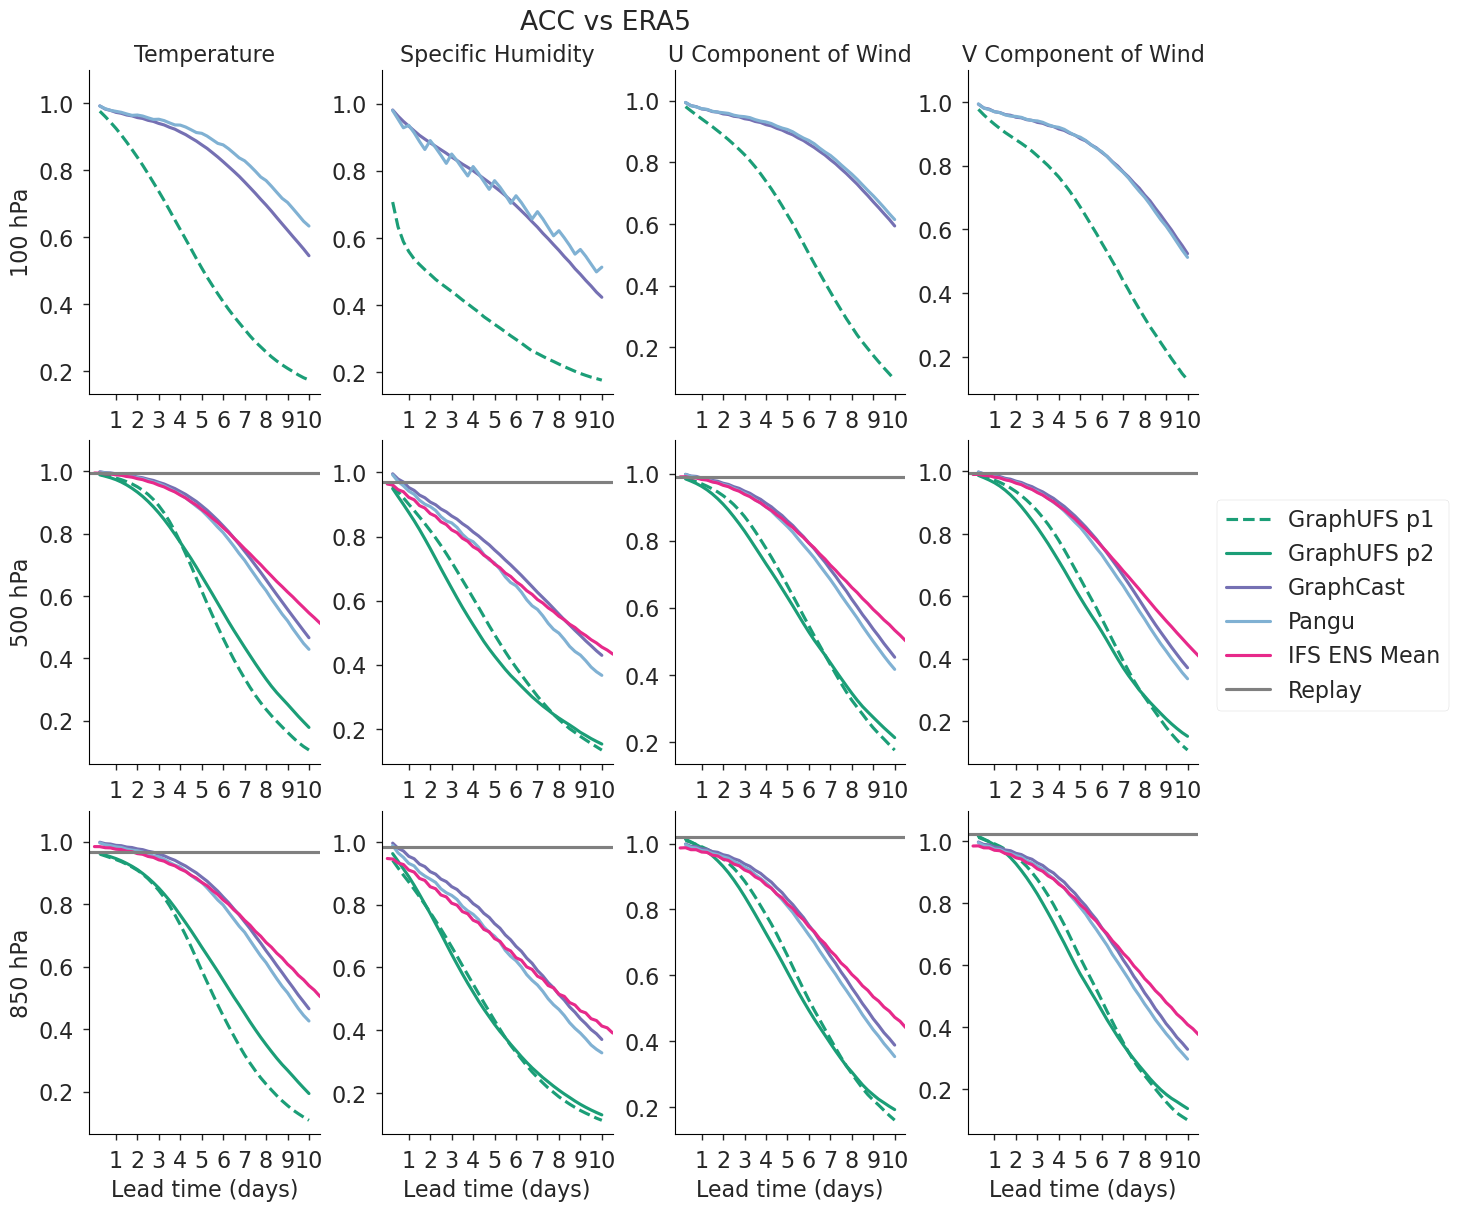

In [49]:
fig, axs = lp.plot_levels(errors, truth="ERA5", metric="acc", color=color, linestyle=ls)
[ax.set(ylim=[None, 1.1]) for ax in axs.flatten()]
fig.savefig(f"{fig_dir}/acc_vs_era5_levels.jpeg", bbox_inches="tight", dpi=300)

## Bias vs HRES

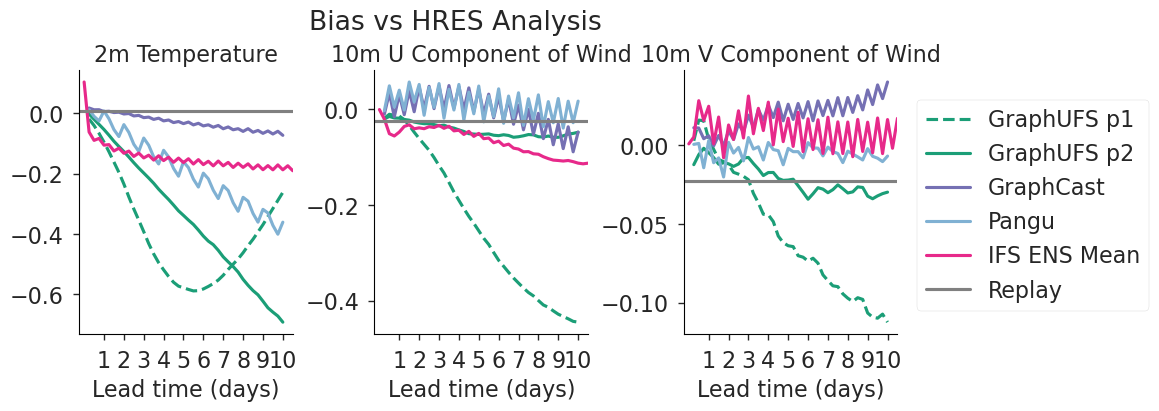

In [51]:
fig, axs = lp.plot_surface(errors, truth="HRES Analysis", metric="bias", color=color, linestyle=ls)
#axs[0].set(ylim=[-.4, .4])
#axs[1].set(ylim=[-.5, .5])
#axs[2].set(ylim=[-.2, .2])
fig.savefig(f"{fig_dir}/bias_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

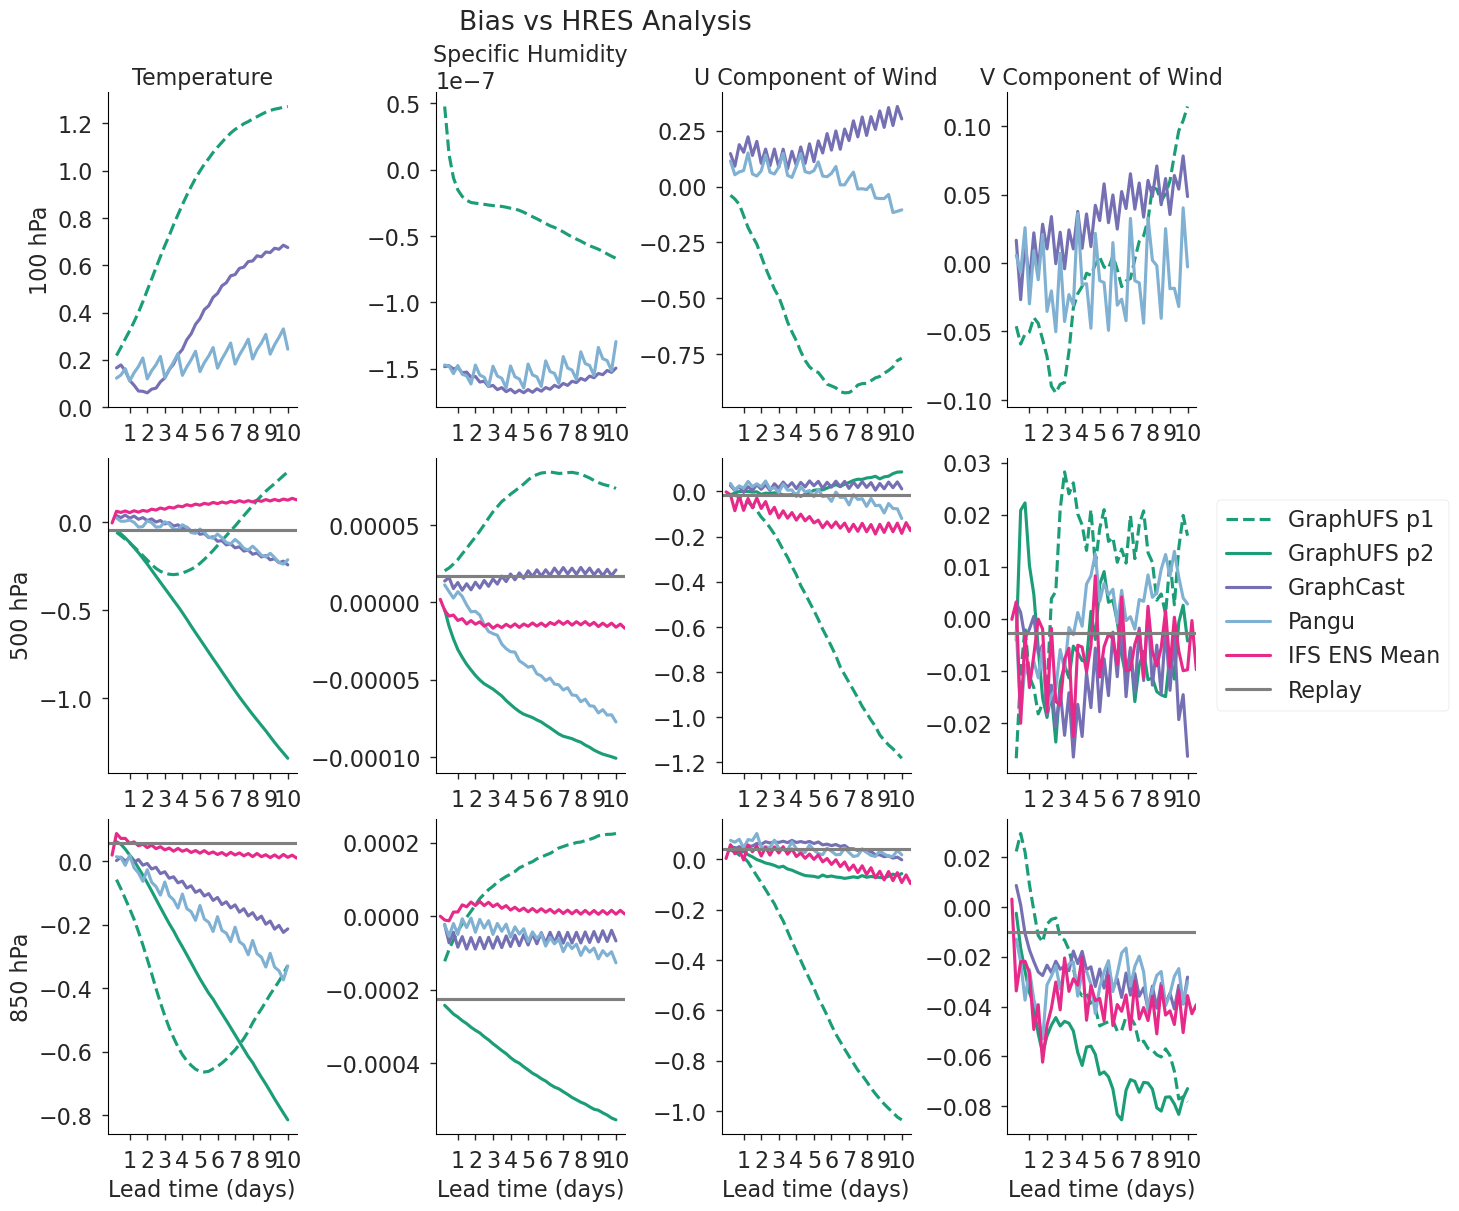

In [52]:
fig, axs = lp.plot_levels(errors, truth="HRES Analysis", metric="bias", color=color, linestyle=ls)
#axs[0,0].set(ylim=[-1.5, 1.5])
#axs[1,0].set(ylim=[-0.89, 0.89],yticks=np.linspace(-.75, .75, 7))
#axs[2,0].set(ylim=[-.5, .5])
#
#axs[0,1].set(ylim=[-2e-7, 2e-7])
#axs[1,1].set(ylim=[-8.5e-5, 8.5e-5])
#axs[2,1].set(ylim=[-2.5e-4, 2.5e-4])
#
#axs[0,2].set(ylim=[-3, .5])
#axs[1,2].set(ylim=[-1.6, 1.6])
#axs[2,2].set(ylim=[-.9, .9])
#
#axs[0, 3].set(ylim=[-.5, .5])
#axs[1, 3].set(ylim=[-.2, .2])
#axs[2, 3].set(ylim=[-.09, .09])
fig.savefig(f"{fig_dir}/bias_vs_hres_levels.jpeg", bbox_inches="tight", dpi=300)

## Relative Error

Originally I was thinking
$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{trainer}_1, \text{trainer}_2)}$$

e.g. the ERA5 version of the plot shows

$$ \dfrac{|\text{GraphUFS} - \text{Replay}|}{|\text{Replay} - \text{ERA5}|}$$
or
$$ \dfrac{|\text{GraphCast} - \text{ERA5}|}{|\text{Replay} - \text{ERA5}|}$$
$$ \dfrac{|\text{Pangu} - \text{ERA5}|}{|\text{Replay} - \text{ERA5}|}$$
and same for Pangu.

Ideally we could also do

$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{trainer}, \text{independent dataset})}$$

But we don't have error between ERA5 and HRES Analysis immediately available, so the HRES version of the plot shows

$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{Replay}, \text{HRES Analysis})}$$

Which no matter what gives us some kind of independent estimate of "how close we should be" for the denominator, even when we use it on a dataset trained on ERA5.

In [36]:
gvr = open_dataset("/p2-lustre/p2/inference/validation/graphufs_vs_replay_240h_deterministic.nc")

In [37]:
sfc = ["surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind", "2m_temperature", "10m_wind_vector"]

In [38]:
relative_errors = {
    "GraphUFS": {
        "HRES Analysis": gvr[sfc] / errors["Replay"]["HRES Analysis"][sfc],
        "ERA5": gvr[sfc] / errors["Replay"]["ERA5"][sfc],
    },
}

In [39]:
sfc.remove("surface_pressure")

In [40]:
for key in ["GraphCast", "Pangu"]:
    relative_errors[key] = {
        "HRES Analysis": errors[key]["ERA5"][sfc] / errors["Replay"]["HRES Analysis"][sfc],
        "ERA5": errors[key]["ERA5"][sfc] / errors["Replay"]["ERA5"][sfc],
    }

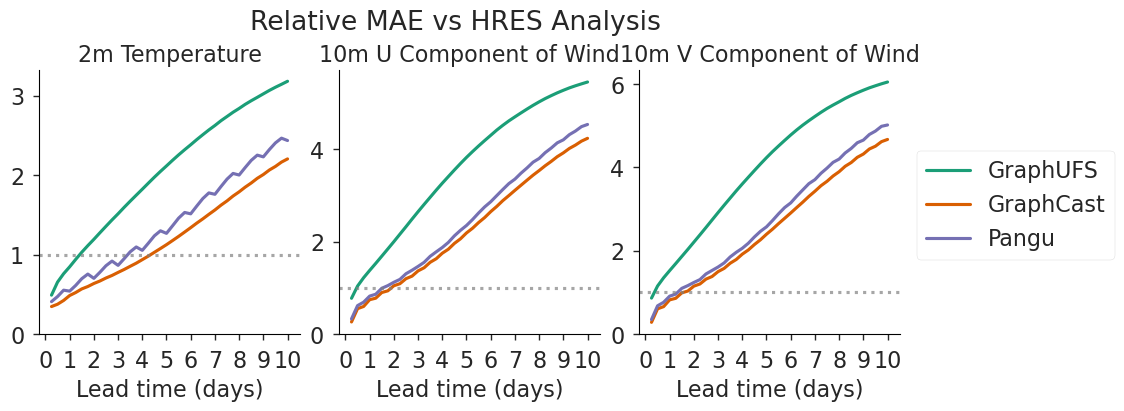

In [42]:
fig, axs = lp.plot_surface(
    relative_errors,
    truth="HRES Analysis",
    color=color, linestyle=ls
)
fig.suptitle("Relative MAE vs HRES Analysis")
[ax.axhline(y=1, ls=":", alpha=.7, color="gray") for ax in axs]
[ax.set(xticks=np.arange(0,10*24+1, 24), xticklabels=np.arange(11)) for ax in axs]
fig.savefig(f"{fig_dir}/relative_mae_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

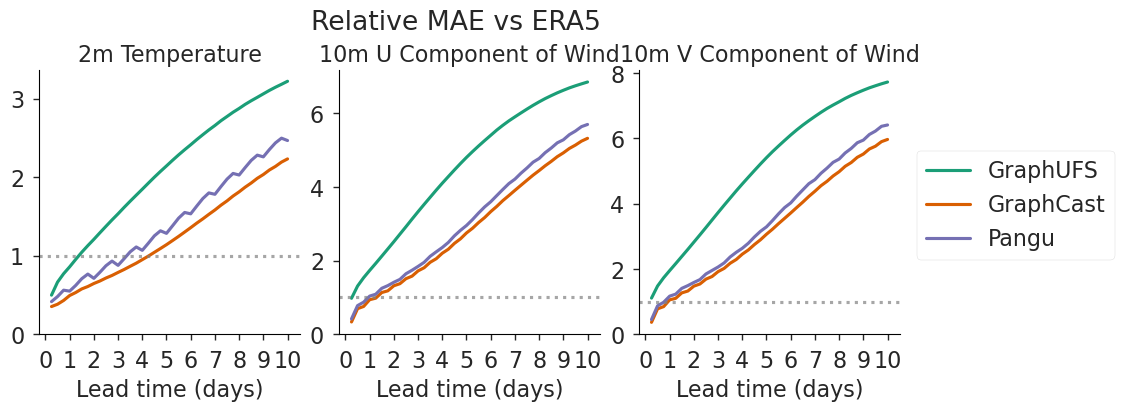

In [43]:
fig, axs = lp.plot_surface(
    relative_errors,
    truth="ERA5",
)
fig.suptitle("Relative MAE vs ERA5")
[ax.axhline(y=1, ls=":", alpha=.7, color="gray") for ax in axs]
[ax.set(xticks=np.arange(0,10*24+1, 24), xticklabels=np.arange(11)) for ax in axs]
fig.savefig(f"{fig_dir}/relative_mae_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)